## Loading Data 

Fetching the dataset from Github

In [2]:
!wget2 --no-clobber -q https://raw.githubusercontent.com/MainakRepositor/Datasets/refs/heads/master/Job_Placement_Data.csv 

In [3]:
import pandas as pd
import numpy as np

Loading the dataset into a pandas dataframe

In [4]:
df = pd.read_csv("Job_Placement_Data.csv")
df.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


Checking for NA values

In [5]:
df.isna().sum()

gender                 0
ssc_percentage         0
ssc_board              0
hsc_percentage         0
hsc_board              0
hsc_subject            0
degree_percentage      0
undergrad_degree       0
work_experience        0
emp_test_percentage    0
specialisation         0
mba_percent            0
status                 0
dtype: int64

## Preprocessing Data 

Seperating the categorical and numerical features as each requires a different type of Naive Bayes Model

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_features = ["gender", "ssc_board", "hsc_board", "hsc_subject", "undergrad_degree", "work_experience","specialisation"]
df_numerical_only = df.drop(categorical_features + ["status"], axis=1)
df_categorical_only = df[categorical_features]
target = df[["status"]]

In [7]:
df_numerical_only.head()

,ssc_percentage,hsc_percentage,degree_percentage,emp_test_percentage,mba_percent
0,67.00,91.00,58.00,55.0,58.80
1,79.33,78.33,77.48,86.5,66.28
2,65.00,68.00,64.00,75.0,57.80
3,56.00,52.00,52.00,66.0,59.43
4,85.80,73.60,73.30,96.8,55.50


In [8]:
df_categorical_only.head()

,gender,ssc_board,hsc_board,hsc_subject,undergrad_degree,work_experience,specialisation
0,M,Others,Others,Commerce,Sci&Tech,No,Mkt&HR
1,M,Central,Others,Science,Sci&Tech,Yes,Mkt&Fin
2,M,Central,Central,Arts,Comm&Mgmt,No,Mkt&Fin
3,M,Central,Central,Science,Sci&Tech,No,Mkt&HR
4,M,Central,Central,Commerce,Comm&Mgmt,No,Mkt&Fin


Encoding all the Categorical Columns for our Categorical Naive Bayes Model

In [9]:
import warnings
warnings.filterwarnings("ignore")

for col in df_categorical_only.columns:
    le = LabelEncoder()
    df_categorical_only[col] = le.fit_transform(df_categorical_only[col])

df_categorical_only.head()

,gender,ssc_board,hsc_board,hsc_subject,undergrad_degree,work_experience,specialisation
0,1,1,1,1,2,0,1
1,1,0,1,2,2,1,0
2,1,0,0,0,0,0,0
3,1,0,0,2,2,0,1
4,1,0,0,1,0,0,0


Standardizing the numerical values

In [10]:
for col in df_numerical_only.columns:
    scaler = StandardScaler()
    df_numerical_only[col] = scaler.fit_transform(df_numerical_only[[col]])

df_numerical_only.head()

,ssc_percentage,hsc_percentage,degree_percentage,emp_test_percentage,mba_percent
0,-0.028087,2.268812,-1.140102,-1.291091,-0.597647
1,1.113369,1.103448,1.513267,1.087157,0.687620
2,-0.213238,0.153313,-0.322843,0.218908,-0.769474
3,-1.046417,-1.318339,-1.957362,-0.460592,-0.489396
4,1.712332,0.668391,0.943909,1.864806,-1.164676


Encoding the target variable

In [11]:
encoder = LabelEncoder()
target = encoder.fit_transform(target)
np.unique(target)

array([0, 1])

## Splitting into training and testing sets 

In [12]:
from sklearn.model_selection import train_test_split
X_cat = df_categorical_only
X_num = df_numerical_only
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat, X_num, target, 
    test_size=0.3, random_state=42, stratify=target
)

## Training SkLearn Naive Bayes Models 
* Gaussian Naive Bayes for Numerical Features
* Categorical Naive Bayes for Categorical Features

> Combining the implementations since 
> $P(status|X_{numerical},X_{categorical}) \propto P(status|X_{numerical}) \cdot P(status|X_{categorical}) $

In [13]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

model_gaussian = GaussianNB()
model_categorical = CategoricalNB()
model_categorical.fit(X_cat_train, y_train)
model_gaussian.fit(X_num_train, y_train)
print("Training Complete!")

Training Complete!


Making predictions on the test set and getting the probablities

In [14]:
cat_probabilities = model_categorical.predict_proba(X_cat_test)
num_probabilities = model_gaussian.predict_proba(X_num_test)

Calculating the joint probablity of the prediction given categorical as well as numerical features

In [21]:
combined_probs = cat_probabilities * num_probabilities
combined_probs = combined_probs / combined_probs.sum(axis=1, keepdims=True)

In [23]:
y_pred = np.argmax(combined_probs, axis=1)

## Visualizing the performance of the classifier on the test set 

Plotting the confusion matrix

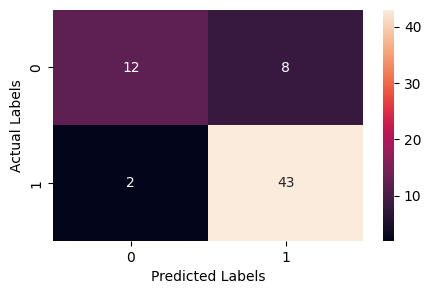

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

Printing the Classification report

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        20
           1       0.84      0.96      0.90        45

    accuracy                           0.85        65
   macro avg       0.85      0.78      0.80        65
weighted avg       0.85      0.85      0.84        65



Thus our Naive Bayes Model has an overall accuracy of 85%